In [123]:
#import the essential libraries and modules that the ticket classification and management system relies on
import pandas as pd
import sqlite3
import uuid
import logging
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [124]:
# === setup basic configuration for logging and define a constant random seed value used throughout the program ===
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
RANDOM_SEED = 42

In [125]:
# Load and preprocess dataset
#use the Pandas library to read data from an Excel file named DATASET-4.xlsx into a DataFrame
df = pd.read_excel('DATASET-4.xlsx')

In [126]:
# Filter out technicians (classes) with fewer than 2 samples to allow stratified splitting
counts = df['RESOLVED_BY'].value_counts()
valid_labels = counts[counts >= 2].index
df = df[df['RESOLVED_BY'].isin(valid_labels)].copy()

In [127]:
#  Encode technician names as numeric labels for ML
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['RESOLVED_BY'].astype(str))

In [128]:
# Feature creation: Combine complaint description, region, and district into one text field for features
df['combined_text'] = df.apply(lambda r: f"{r['COMPLAINT']} {r['REGION']} {r['DISTRICT']}", axis=1) 


In [129]:
# Train-test split with stratification for reproducibility
# Use stratified shuffle split to maintain label proportions
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'], y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

In [130]:
# create and trains a machine learning pipeline combining text feature extraction with a classifier:
#Pipeline: TF-IDF + Linear SVM

model_pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    SVC(kernel='linear', probability=True, random_state=RANDOM_SEED)
)

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('svc',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [131]:
# Evaluate the trained model on test data and log the performance
y_pred = model_pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
logging.info(f"Test Accuracy: {acc:.4f}")
logging.info(f"Confusion Matrix:\n{conf_mat}")

2025-11-23 01:15:18,648 INFO: Test Accuracy: 0.9055
2025-11-23 01:15:18,649 INFO: Confusion Matrix:
[[ 1  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0 11]]


In [132]:
#  SQLite database setup, connection and provide core database operations
conn = sqlite3.connect('ticketing_system.db')

def add_missing_columns():
    cur = conn.cursor()
    for col in ['complaint_type', 'region', 'district', 'assigned_technician']:
        try:
            cur.execute(f"ALTER TABLE tickets ADD COLUMN {col} TEXT")
        except sqlite3.OperationalError:
            pass
    conn.commit()

def create_table_if_not_exists():
    cur = conn.cursor()
    cur.execute('''
        CREATE TABLE IF NOT EXISTS tickets (
            ticket_id INTEGER PRIMARY KEY AUTOINCREMENT,
            date_created TEXT DEFAULT CURRENT_TIMESTAMP,
            user TEXT,
            phone_number TEXT,
            issue_description TEXT,
            complaint_type TEXT,
            priority TEXT,
            status TEXT DEFAULT 'Open',
            reference TEXT UNIQUE,
            region TEXT,
            district TEXT,
            assigned_technician TEXT
        )
    ''')
    conn.commit()

create_table_if_not_exists()
add_missing_columns()

def generate_reference():
    return str(uuid.uuid4()).replace('-', '')[:6]

def predict_technician(issue_description: str, region: str, district: str) -> str:
    combined = f"{issue_description} {region} {district}"
    pred_encoded = model_pipeline.predict([combined])[0]
    return label_encoder.inverse_transform([pred_encoded])[0]

def add_ticket(user, phone, issue, complaint_type, priority, region, district):
    if not (phone.isdigit() and len(phone) == 10):
        raise ValueError("Phone number must be 10 digits.")
    assigned_tech = predict_technician(issue, region, district)
    ref = generate_reference()
    cur = conn.cursor()
    cur.execute('''
        INSERT INTO tickets (user, phone_number, issue_description, complaint_type, priority, reference, region, district, assigned_technician)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (user, phone, issue, complaint_type, priority, ref, region, district, assigned_tech))
    conn.commit()
    return ref

def update_status(reference, new_status):
    cur = conn.cursor()
    cur.execute('UPDATE tickets SET status = ? WHERE reference = ?', (new_status, reference))
    conn.commit()
    if cur.rowcount == 0:
        raise ValueError(f"No ticket found with reference '{reference}'")

def get_all_tickets():
    query = '''
    SELECT ticket_id,
           datetime(date_created, 'localtime') as date_created,
           user, phone_number, issue_description, complaint_type,
           priority, status, reference, region, district, assigned_technician
    FROM tickets
    ORDER BY date_created DESC
    '''
    return pd.read_sql_query(query, conn)

def get_ticket_by_reference(ref):
    cur = conn.cursor()
    query = '''
    SELECT ticket_id,
           datetime(date_created, 'localtime') as date_created,
           user, phone_number, issue_description, complaint_type,
           priority, status, reference, region, district, assigned_technician
    FROM tickets
    WHERE reference = ?
    '''
    cur.execute(query, (ref,))
    row = cur.fetchone()
    cols = [desc[0] for desc in cur.description]
    return row, cols

In [133]:
# --- UI Setup ---
complaint_types = sorted(df['COMPLAINT_TYPE'].dropna().unique()) if 'COMPLAINT_TYPE' in df.columns else []
region_district_map = df.groupby('REGION')['DISTRICT'].unique().apply(list).to_dict()

In [134]:
# -- Ticket Submission Widgets --
user_text = widgets.Text(description='User:')
phone_text = widgets.Text(description='Phone Number:')
issue_text = widgets.Textarea(description='Issue:')
complaint_dropdown = widgets.Dropdown(options=complaint_types, description='Complaint Type:')
priority_dropdown = widgets.Dropdown(options=['Low', 'Medium', 'High', 'Critical'], value='Medium', description='Priority:')
region_dropdown = widgets.Dropdown(options=sorted(region_district_map.keys()), description='Region:')
district_dropdown = widgets.Dropdown(description='District:', options=[])

submit_button = widgets.Button(description='Submit Ticket')
submit_output = widgets.Output()

def on_region_change(change):
    if change['name'] == 'value' and change['type'] == 'change':
        district_dropdown.options = region_district_map.get(change['new'], [])

region_dropdown.observe(on_region_change)

def on_submit_clicked(b):
    with submit_output:
        clear_output()
        if not all([user_text.value.strip(), phone_text.value.strip(), issue_text.value.strip()]):
            print("User, Phone Number, and Issue Description are required.")
            return
        if not region_dropdown.value or not district_dropdown.value:
            print("Select Region and District.")
            return
        try:
            ref = add_ticket(
                user_text.value.strip(),
                phone_text.value.strip(),
                issue_text.value.strip(),
                complaint_dropdown.value,
                priority_dropdown.value,
                region_dropdown.value,
                district_dropdown.value
            )
            assigned_tech = predict_technician(issue_text.value.strip(), region_dropdown.value, district_dropdown.value)
            print(f"Ticket submitted! Reference: {ref}\nAssigned Technician: {assigned_tech}")
            # Reset inputs
            user_text.value = ''
            phone_text.value = ''
            issue_text.value = ''
            complaint_dropdown.value = complaint_types[0] if complaint_types else None
            priority_dropdown.value = 'Medium'
            region_dropdown.value = None
            district_dropdown.options = []
            refresh_tickets()
        except Exception as e:
            print(f"Error: {e}")

submit_button.on_click(on_submit_clicked)

In [135]:
# -- Status Update Widgets --
ticket_ref_text = widgets.Text(description='Ticket Ref:')
status_dropdown = widgets.Dropdown(options=['Open', 'In Progress', 'Resolved', 'Closed'], value='Open', description='Status:')
update_button = widgets.Button(description='Update Status')
update_output = widgets.Output()

def on_update_clicked(b):
    with update_output:
        clear_output()
        try:
            update_status(ticket_ref_text.value.strip(), status_dropdown.value)
            print(f"Ticket '{ticket_ref_text.value.strip()}' updated to '{status_dropdown.value}'")
            refresh_tickets()
        except Exception as e:
            print(f"Error: {e}")

update_button.on_click(on_update_clicked)

In [136]:
# -- Ticket Search Widgets --
search_ticket_input = widgets.Text(description="Search Ref:", placeholder="Enter ticket reference")
search_ticket_button = widgets.Button(description="Search Ticket")
search_output = widgets.Output()

def on_search_ticket_clicked(b):
    with search_output:
        clear_output()
        ref = search_ticket_input.value.strip()
        if not ref:
            print("Enter a reference to search.")
            return
        row, cols = get_ticket_by_reference(ref)
        if row is None:
            print("No ticket found.")
            return
        md = "| Field | Value |\n|-------|-------|\n"
        for k, v in zip(cols, row):
            md += f"| {k} | {v} |\n"
        display(Markdown(md))

search_ticket_button.on_click(on_search_ticket_clicked)

In [137]:
# -- Tickets Display and Refresh --
tickets_output = widgets.Output()

def refresh_tickets():
    with tickets_output:
        clear_output()
        df_tickets = get_all_tickets()
        if df_tickets.empty:
            print("No tickets available.")
            return
        print("Current Tickets (Newest First):")
        display(df_tickets)
        print("\nTickets Count by Priority:")
        display(df_tickets['priority'].value_counts().to_frame().reset_index().rename(columns={'index': 'Priority', 'priority': 'Count'}))

refresh_tickets()

In [140]:
# -- Display UI --
display(
    widgets.HTML("<h2>Submit New Ticket</h2>"),
    user_text, phone_text, issue_text, complaint_dropdown,
    priority_dropdown, region_dropdown, district_dropdown,
    submit_button, submit_output,
    widgets.HTML("<hr><h2>Update Ticket Status</h2>"),
    ticket_ref_text, status_dropdown, update_button, update_output,
    widgets.HTML("<hr><h2>Search Ticket</h2>"),
    search_ticket_input, search_ticket_button, search_output,
    widgets.HTML("<hr><h2>All Tickets Overview</h2>"),
    tickets_output
)

HTML(value='<h2>Submit New Ticket</h2>')

Text(value='', description='User:')

Text(value='', description='Phone Number:')

Textarea(value='', description='Issue:')

Dropdown(description='Complaint Type:', options=('Application - Credit Meter', 'Application - Prepaid Meter', …

Dropdown(description='Priority:', index=1, options=('Low', 'Medium', 'High', 'Critical'), value='Medium')

Dropdown(description='Region:', options=('CENTRAL', 'NORTH EAST', 'WESTERN'), value=None)

Dropdown(description='District:', options=(), value=None)

Button(description='Submit Ticket', style=ButtonStyle())

Output(outputs=({'name': 'stdout', 'text': 'Ticket submitted! Reference: 8124bd\nAssigned Technician: EYAMU MA…

HTML(value='<hr><h2>Update Ticket Status</h2>')

Text(value='', description='Ticket Ref:')

Dropdown(description='Status:', options=('Open', 'In Progress', 'Resolved', 'Closed'), value='Open')

Button(description='Update Status', style=ButtonStyle())

Output()

HTML(value='<hr><h2>Search Ticket</h2>')

Text(value='', description='Search Ref:', placeholder='Enter ticket reference')

Button(description='Search Ticket', style=ButtonStyle())

Output()

HTML(value='<hr><h2>All Tickets Overview</h2>')

Output(outputs=({'name': 'stdout', 'text': 'Current Tickets (Newest First):\n', 'output_type': 'stream'}, {'ou…

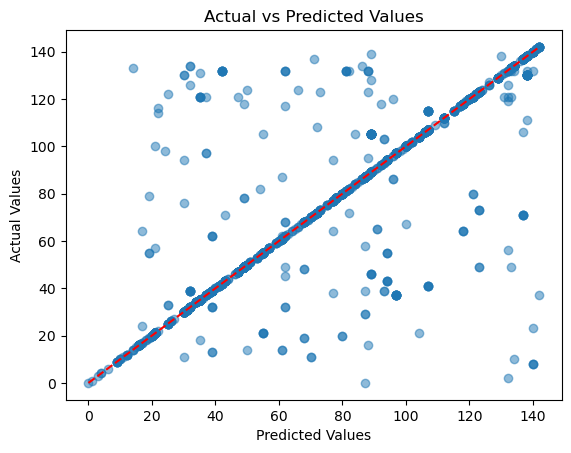

In [141]:
#create a scatter plot comparing predicted values against actual values and adds a diagonal reference line:
# y_test: actual labels
# y_pred: predicted labels from model
#Use 50% alpha va

plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Algorithms Used
•	Support Vector Machine (SVM): A linear SVM classifier is used due to its effectiveness in high-dimensional sparse text data.
•	TF-IDF (Term Frequency-Inverse Document Frequency): Converts text into numeric feature vectors emphasizing discriminative terms.
•	Label Encoding: Transforms categorical technician labels into integers for supervised learning.
The model jointly learns from textual and geographic context to predict the resolving technician.